In [21]:
import random

from tqdm import tqdm

import torch
import torch.nn.functional as F
from   torch.utils.data import Dataset, DataLoader
from   torch import nn

## Prepare Data
 - Load
 - Convert characters to ints
 - Convert words -> characters -> ints -> tensors
 - Split into 80% training 20% validation

In [22]:
# https://github.com/MK2112/nn-zero-to-hero-notes/blob/main/names.txt

with open('./names.txt', 'r') as f:
    words = f.read().splitlines()
    
words[0:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [23]:
# copied from the video
chars = sorted(list(set(''.join(words))))
stoi  = {s:i+1 for i,s in enumerate(chars) }
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [24]:
def w2ten(w = 'emma'):
    pass

w = 'emma'
w = f'.{w}.'
w = [stoi[e] for e in w] 
w = [[i,j] for i,j in zip(w, w[1:])]
torch.tensor(w)

tensor([[ 0,  5],
        [ 5, 13],
        [13, 13],
        [13,  1],
        [ 1,  0]])

In [25]:
def w2ten(w = 'emma'):
    w = f'.{w}.'
    w = [stoi[e] for e in w] 
    w = [[i,j] for i,j in zip(w, w[1:])]
    return torch.tensor(w)

In [26]:
# optional way to visualize the tensor
# import numpy as np
# import matplotlib.pyplot as plt
# plt.imshow(w2ten().numpy())

In [27]:
random.seed(42)
random.shuffle(words)
words[0:10]

['yuheng',
 'diondre',
 'xavien',
 'jori',
 'juanluis',
 'erandi',
 'phia',
 'samatha',
 'phoenix',
 'emmelynn']

In [28]:
trn_cutoff = int(len(words) * .8)

trn_bigram = torch.concat([w2ten(w = w) for w in tqdm(words[0:trn_cutoff])])
val_bigram = torch.concat([w2ten(w = w) for w in tqdm(words[trn_cutoff:len(words)])])

100%|██████████| 6407/6407 [00:00<00:00, 208289.65it/s]


## Create training and validation dataloaders

In [29]:
class ds(Dataset):
    def __init__(self, c0, c1):
        self.c0, self.c1 = c0, c1
    
    def __len__(self):
        return len(self.c0)
    
    def __getitem__(self, idx):
        return self.c0[idx], self.c1[idx]

In [30]:
# create training /validation dataloaders

# boolean for if a gpu is available
gpu = torch.cuda.is_available()


trn_dl = DataLoader(
    dataset = ds(                    # A if bool else B    move data to the gpu if a gpu is available.
        c0 = trn_bigram[:, 0].to('cuda') if gpu else trn_bigram[:, 0],
        c1 = trn_bigram[:, 1].to('cuda') if gpu else trn_bigram[:, 1]
        ),
    batch_size = 256,
    shuffle = False
)



val_dl = DataLoader(
    dataset = ds(
        c0 = val_bigram[:, 0].to('cuda') if gpu else val_bigram[:, 0],
        c1 = val_bigram[:, 1].to('cuda') if gpu else val_bigram[:, 1]
        ),
    batch_size = 256,
    shuffle = False
)

In [31]:
# Transform int -> one hot encoding 
(val_bigram[0:5, 0],
 F.one_hot(val_bigram[0:5, 0], num_classes=27).float()
)

(tensor([ 0,  1, 13,  1, 25]),
 tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0.]]))

## Work through one prediction

In [32]:
# Define a model to accept one hot encoding and produce probability (as logits) of next character
class BGM(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(27, 27)
        )
    
    def forward(self, xi):
        logits = self.layers(xi)
        return logits

In [33]:
n = BGM().to('cuda') if gpu else BGM()

In [34]:
c0, c1 = next(iter(trn_dl))
c0 = F.one_hot(c0, num_classes=27).float()

In [35]:
logits = n(c0)
logits

tensor([[-0.2010, -0.2310,  0.1845,  ..., -0.3318, -0.0121,  0.0962],
        [-0.0443,  0.0086,  0.0416,  ..., -0.0809,  0.1607,  0.2316],
        [-0.3589,  0.0689,  0.1868,  ..., -0.0774,  0.1167,  0.2589],
        ...,
        [-0.1110, -0.0149, -0.1437,  ..., -0.3440,  0.1056,  0.2240],
        [-0.2379, -0.0942,  0.0034,  ..., -0.2909,  0.0668, -0.0044],
        [-0.2747, -0.1897,  0.1056,  ..., -0.0434, -0.0088, -0.0432]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [36]:
# calculate the loss for this minibatch
loss_fn = nn.CrossEntropyLoss()
loss_fn(logits, F.one_hot(c1, num_classes=27).float())

tensor(3.3535, device='cuda:0', grad_fn=<DivBackward1>)

In [37]:
# Convert logits to probabilities
pred_probab = F.softmax(logits, dim=1)
pred_probab

tensor([[0.0302, 0.0293, 0.0445,  ..., 0.0265, 0.0365, 0.0407],
        [0.0345, 0.0364, 0.0376,  ..., 0.0333, 0.0424, 0.0455],
        [0.0257, 0.0394, 0.0443,  ..., 0.0340, 0.0413, 0.0476],
        ...,
        [0.0334, 0.0368, 0.0323,  ..., 0.0265, 0.0415, 0.0467],
        [0.0304, 0.0351, 0.0387,  ..., 0.0288, 0.0412, 0.0384],
        [0.0278, 0.0303, 0.0407,  ..., 0.0351, 0.0363, 0.0351]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [38]:
# get the most likely next character
pred_probab.argmax(1)

tensor([22, 22,  7, 22, 16, 22, 25, 22, 16, 22, 22, 22, 16, 22, 16, 22,  3,  7,
        16, 22, 16, 22, 22,  7, 22, 22, 22, 22,  7,  7,  7, 22, 21,  7, 22,  3,
        22, 16, 22,  7, 22, 16, 22, 22, 22, 22, 22,  7, 22,  3,  7, 26,  7, 25,
        22,  7, 22, 22, 22, 22, 16, 22, 22,  3, 22, 16, 26, 26, 16, 21, 22, 22,
        22, 22, 22, 22, 21, 21,  7, 22, 22, 22, 22, 21, 21, 22,  3, 22, 17,  7,
        21, 21,  7, 21, 22, 21, 22, 22,  7, 16, 16, 21,  7, 22, 16, 16, 22,  7,
        22,  3, 16, 22, 22, 22, 22, 16, 22,  7, 16, 21, 16, 22, 22, 22, 16,  7,
        22, 21, 16, 22, 22,  7, 25, 22,  7, 22, 22, 17, 22, 21, 22, 22, 16, 22,
        25,  7, 16, 16, 22, 22, 22,  7, 16, 22, 22, 22, 16, 22, 25, 16, 22, 22,
        16, 16, 16,  7, 22, 22, 22,  7, 22, 16, 21, 21,  7, 22, 26, 16, 17, 17,
         7, 22, 16, 25,  7, 22, 22,  7,  7,  3, 25, 22, 17, 16, 22, 25,  7, 21,
        22, 22,  7, 22, 22, 22,  7, 22, 21, 16, 22, 22,  7, 21, 21, 16,  7, 22,
        22, 16, 22, 26, 22, 16, 22, 21, 

## Define training behavior for one epoch and train

In [39]:
def train_epoch(dataloader, model, loss_fn, optimizer, return_loss):
    model.train()
    for i, (c0, c1) in enumerate(dataloader):
        c0 = F.one_hot(c0, num_classes=27).float()
        c1 = F.one_hot(c1, num_classes=27).float()

        logits = n(c0)
        loss = loss_fn(logits, c1)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if return_loss:
            return loss.item()

In [40]:
# define bigram model
n = BGM().to('cuda') if gpu else BGM()

# set up optimizer
opt = torch.optim.SGD(n.parameters(), lr=1e-3)

# test training
train_epoch(dataloader = trn_dl, model = n, loss_fn = nn.CrossEntropyLoss(), optimizer = opt, return_loss = True)

3.2935664653778076

In [41]:
print('epoch\tloss')
print('-----\t------------------')
for k in range(2000):
    _ = train_epoch(dataloader = trn_dl, model = n, loss_fn = nn.CrossEntropyLoss(), optimizer = opt, return_loss = True)
    if (k % 10) == 0:
        print(f'{k}\t{_}')

epoch	loss
-----	------------------
0	3.2935242652893066
10	3.2931015491485596
20	3.2926793098449707
30	3.292257308959961
40	3.291835308074951
50	3.2914137840270996
60	3.2909927368164062
70	3.290571689605713
80	3.2901511192321777
90	3.289731025695801
100	3.289310932159424
110	3.288891315460205
120	3.2884719371795654
130	3.288053035736084
140	3.2876338958740234
150	3.2872157096862793
160	3.286797523498535
170	3.286379814147949
180	3.2859621047973633
190	3.2855448722839355
200	3.285127639770508
210	3.2847111225128174
220	3.284294605255127
230	3.2838785648345947
240	3.2834627628326416
250	3.2830471992492676
260	3.2826318740844727
270	3.282217264175415
280	3.2818026542663574
290	3.281388282775879
300	3.2809741497039795
310	3.2805604934692383
320	3.280147075653076
330	3.2797341346740723
340	3.2793211936950684
350	3.2789087295532227
360	3.278496265411377
370	3.2780842781066895
380	3.27767276763916
390	3.27726149559021
400	3.276850461959839
410	3.276439666748047
420	3.276029109954834
430	3.27

## What about generation?

In [42]:
out = [0]

c0 = torch.tensor([0]).to('cuda') if gpu else torch.tensor([0])
c0

tensor([0], device='cuda:0')

In [43]:
# Always choosing the next most likely character
out = [0]

c0 = torch.tensor([0]).to('cuda') if gpu else torch.tensor([0])

for i in range(10):
    c0 = F.one_hot(c0, num_classes=27).float()
    logits = n(c0)
    pred_probab = F.softmax(logits, dim=1)
    pred = pred_probab.argmax(1)

    out.append(pred.item())
    c0 = pred

(out, 
 ''.join([itos[i] for i in out]))


([0, 5, 14, 0, 5, 14, 0, 5, 14, 0, 5], '.en.en.en.e')

In [44]:
# Sampling from prob. dist.
out = [0]

c0 = torch.tensor([0]).to('cuda') if gpu else torch.tensor([0])

for i in range(10):
    c0 = F.one_hot(c0, num_classes=27).float()
    logits = n(c0)
    pred_probab = F.softmax(logits, dim=1)
    # pred = pred_probab.argmax(1)
    pred = torch.multinomial(pred_probab, 1)[0]

    out.append(pred.item())
    c0 = pred

(out, 
 ''.join([itos[i] for i in out]))


([0, 5, 10, 4, 11, 17, 11, 14, 2, 0, 19], '.ejdkqknb.s')

In [45]:
# Get generation to stop after a start/stop character
out = [0]

c0 = torch.tensor([0]).to('cuda') if gpu else torch.tensor([0])

# for i in range(100):
while True:
    c0 = F.one_hot(c0, num_classes=27).float()
    logits = n(c0)
    pred_probab = F.softmax(logits, dim=1)
    pred = torch.multinomial(pred_probab, 1)[0]

    out.append(pred.item())
    if pred.item() == 0:
        break

    c0 = pred

(out, 
 ''.join([itos[i] for i in out]))

([0, 4, 6, 2, 4, 24, 10, 2, 1, 15, 19, 5, 25, 15, 26, 16, 0],
 '.dfbdxjbaoseyozp.')

## Extend BGM to allow for generation

In [46]:
# Define a model to accept one hot encoding and produce probability (as logits) of next character
class BGM(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(27, 27)
        )
    
    def forward(self, xi):
        logits = self.layers(xi)
        return logits
    
    def generate(self):
        # Get generation to stop after a start/stop character
        out = [0]
        c0 = torch.tensor([0]).to('cuda') if gpu else torch.tensor([0])

        while True:
            c0 = F.one_hot(c0, num_classes=27).float()
            logits = n(c0)
            pred_probab = F.softmax(logits, dim=1)
            pred = torch.multinomial(pred_probab, 1)[0]

            out.append(pred.item())
            if pred.item() == 0:
                break
            c0 = pred

        return ''.join([itos[i] for i in out])[1:-1]

n = BGM().to('cuda') if gpu else BGM()
n.generate()

'cqiikej'

In [47]:
import matplotlib.pyplot as plt

In [48]:
n = BGM().to('cuda') if gpu else BGM()
opt = torch.optim.SGD(n.parameters(), lr = 1e-3)

history = []
for k in range(2000):
    _ = train_epoch(dataloader = trn_dl, model = n, loss_fn = nn.CrossEntropyLoss(), optimizer = opt, return_loss = True)
    history.append(_)

plt.plot(history)

100%|██████████| 10000/10000 [00:12<00:00, 782.79it/s]


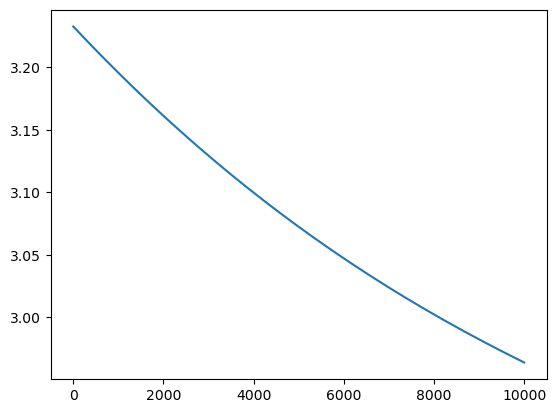

In [49]:
history = []
for k in tqdm(range(10000)):
    _ = train_epoch(dataloader = trn_dl, model = n, loss_fn = nn.CrossEntropyLoss(), optimizer = opt, return_loss = True)
    history.append(_)

plt.plot(history)

In [50]:
print('\n'.join([n.generate() for i in range(10)]))

yhmpgvemjclxae
npfdlyhqoqxdrpjlzdhxnukdfhkt
enbuc
xdule
bvhpnl
ajcuc
balsf
il
yvmor
qudje


100%|██████████| 2000/2000 [00:02<00:00, 793.93it/s]


zgespgxekxqivrvgnibxttzjmudvylaxj
xwclrk
proyjpmrrkaqagyxlznnmnvjga
yklgrsntiqiikywshklo
pkkqudykzdbnfrsdo


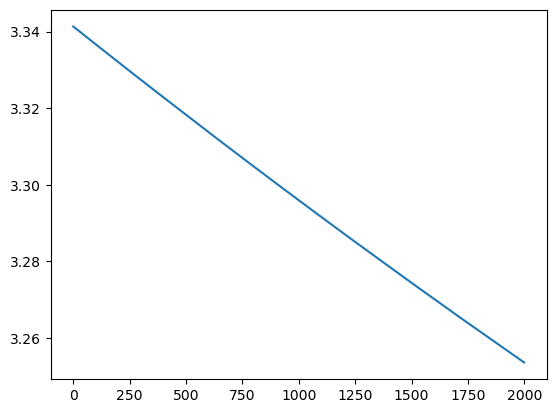

In [51]:
n = BGM().to('cuda') if gpu else BGM()
opt = torch.optim.SGD(n.parameters(), lr = 1e-3)

history = []
for k in tqdm(range(2000)):
    _ = train_epoch(dataloader = trn_dl, model = n, loss_fn = nn.CrossEntropyLoss(), optimizer = opt, return_loss = True)
    history.append(_)

plt.plot(history)
print('\n'.join([n.generate() for i in range(5)]))

100%|██████████| 2000/2000 [00:02<00:00, 740.12it/s]

hona
ty
k
jphelrilbiyf
joy


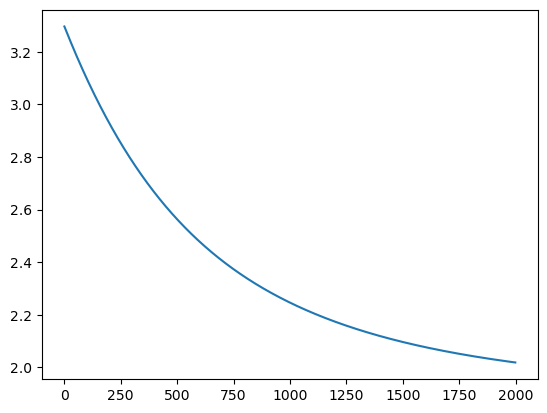

In [52]:
n = BGM().to('cuda') if gpu else BGM()
# opt = torch.optim.SGD(n.parameters(), lr = 1e-3)
opt = torch.optim.AdamW(n.parameters(), lr=1e-3)

history = []
for k in tqdm(range(2000)):
    _ = train_epoch(dataloader = trn_dl, model = n, loss_fn = nn.CrossEntropyLoss(), optimizer = opt, return_loss = True)
    history.append(_)

plt.plot(history)
print('\n'.join([n.generate() for i in range(5)]))

In [53]:

#NOTE: Not much is new here...
# - __init__ changed to accept inputs like the MLP last session
# - __init__ has a new optional activation function
# - forward changed to work with nn.Module list
# - generate is copied from above 

class BGM2(nn.Module):
    def __init__(self, inp= 27, hidden = [], out=27, activation = None):
        super().__init__()
        tmp =[inp]+hidden+[out]
        if activation == None:
            tmp = sum([[nn.Linear(i, j)]             for i,j in zip(tmp, tmp[1:])], [])
            self.layers = nn.ModuleList(tmp)

        else:
            tmp = sum([[nn.Linear(i, j), activation] for i,j in zip(tmp, tmp[1:])], [])    
            self.layers = nn.ModuleList(tmp[0:-1] )

    def forward(self, xi):
        for l in self.layers:
            xi = l(xi)
        logits = xi
        return logits
    
    def generate(self):
        c0 = torch.tensor([0]).to('cuda') if torch.cuda.is_available() else torch.tensor([0])
        out = [c0]

        while ((len(out) == 1) | (out[-1].item() != 0)):
            xi = out[-1]
            xi_enc = F.one_hot(xi, num_classes=27).float()
            logits = self.forward(xi_enc)
            pred_probab = F.softmax(logits, dim=1)
            pred = torch.multinomial(pred_probab, 1)[0]
            out.append(pred)
        
        return [e.item() for e in out]
    
BGM2()

BGM2(
  (layers): ModuleList(
    (0): Linear(in_features=27, out_features=27, bias=True)
  )
)